<a href="https://colab.research.google.com/github/DDoeuiGongju/DoItDeeplearning/blob/main/07_%EB%8B%A4%EC%A4%91%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 다중 분류 신경망
> 다중 분류 신경망을 만들기 위해서 소프트맥스(softmax) 함수와 크로스 엔트로피(cross-entropy) 손실 함수를 알아야 한다.  
이진 분류는 출력층에 뉴런을 하나만 두었다. 다중 분류는 출력층에 분류할 클래스 개수 만큼 뉴런을 놓는다.

> ### 소프트 맥스 함수
- 다중 분류의 문제점: 활성화 출력의 합이 1이 아니면 비교가 어렵다. 즉, 같은 스케일이 아니면 공정하게 비교하기 어렵다는 것이다.
- 해결 방법: 소프트맥스 함수를 적용해 출력 강도 정규화 → 전체 출력값의 합을 1로   
$\frac{e^{z_i}}{e^{z_1}+e^{z_i}+...+e^{z_n}} = \frac{e^{z_i}}{\sum_{i=1}^n{e^{z_i}}}$  
    - ${z_i}$: 출력층의 각 뉴런에서 계산된 선형 출력, $e$: 자연 상수, $n$: 클래스 수   

> ### 크로스 엔트로피 손실 함수    
다중 분류에서 출력층을 통과한 값들은 소프트맥스 함수를 거치며 적절한 확률값으로 변한다. 이 확률값을 이용해 가중지와 절편을 업데이트 하기 위한 손실 함수는 로지스틱 손실 함수의 일반화 버전인 크로스 엔트로피 함수!
- 크로스 엔트로피 손실 함수  
  $L=-\sum_{c=1}^cy_clog(a_c)=-log(a_{y=1})$
    - $c$: 전체 클래스 개수, $a_{y=1}$: 정답 클래스에 해당하는 뉴런의 활성화 출력
    - 분류 문제에서 정답클래스의 타깃은 1이고 나머지는 0이므로 나멎 클래스에 대한 손실 항은 모두 소거
- 로지스틱 손실 함수  
  $L=-(ylog(a)+(1-y)log(1-a))$  
→ 로지스틱 손실 함수는 크로스 엔트로피 손실 함수의 합 기호를 빼고 양성 클래스와 음성 클래스에 대해 나누어 놓은 것
- 크로스 엔크로피 손실 함수 미분
    - 하나의 샘플에 대한 손실 함수의 미분을 유도
    - z에 대해 미분하면 로지스틱 손실 함수의 미분과 정확히 일치  
      → 04장에서 구현한 backword()그대로 사용

## 다중 분류 신경망 구현
- MinibatchNetwork클래스 확장해 다중 분류를 수행하는 MultiClassNetwork클래스 구현
1. 소프트맥스 함수 추가: activation()의 이름을 sigmoid()로 바꾸고 softmax() 추가  
np.exp(z): $z$ 의 각 원소를 $e^z$ 로 만들어줌  
np.sum().reshape: $z$의 각 행의 합 계산 후 열벡터로 바꿔 나눈셈에 적용할 수 있도록 함

2. 정방향 계산: forpass()에 사용된 activation()이름을 sigmoid()로 바꿔줌 

3. 가중치 초기화: 출력층의 뉴런이 2개 이상이므로 가중치 w2의 크기는 (은닉층 뉴런 개수, 클래스 개수), b2의 크기는 클래스 개수 따라 지정

4. fit() 메서드 수정: 가중치 초기화 시 클래수의 개수를 넘겨줌, 다중 분류 문제에서 y, y_val은 2차원 행렬이므로 열벡터 변환 토드 삭제

5. training() 메서드 수정: 출력층의 활성화 함수를  activation()에서 softmax()로 바꿈

6. predict() 메서드 수정: 정방향 계산에서 얻은 출력 중 가장 큰 값의 인덱스 구함. 이 값이 예측 클래스가 됨

7. score() 메서드 수정: predict()메서드의 결과와  타깃 y의 클래스 비교

8. 검증 손실 계산: update_val_loss() 메서드의 활성화 함수를 softmax()로 바꾸고, 로지스팃 손실 계산을 크로스 엔트로피 손실 계산으로 바꿈

In [2]:
# 1. 소프트맥스 함수 추가

class MultiClassNetwork:
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력: 역방향 계산에 필요
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 loss 하이퍼파라미터
        self.l2 = l2               # L2 loss 하이퍼파라미터

    def backprop(self, x, err):
        m = len(x) 

        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad

    def forpass(self, x):                         
        z1 = np.dot(x, self.w1) + self.b1   
        self.a1 = self.sigmoid(z1)           
        z2 = np.dot(self.a1, self.w2) + self.b2   
        return z2
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
        
    def softmax(self, z):
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
    
    def init_weights(self, n_features, n_classes):
        np.random.seed(42)  
        self.w1 = np.random.normal(0, 1, (n_features, self.units))  
        self.b1 = np.zeros(self.units)                               
        self.w2 = np.random.normal(0, 1, (self.units, n_classes))   
        self.b2 = np.zeros(n_classes)

    def fit(self, x, y, epochs=100, x_val=None, y_val=None):          
        self.init_weights(x.shape[1], y.shape[1])
        np.random.seed(42)
        for i in range(epochs):
            loss = 0
            print('.', end='')   # 편의상 훈련의 진행 상황을 볼 수 있도록
            for x_batch, y_batch in self.gen_batch(x, y):           
                a = self.training(x_batch, y_batch)
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += np.sum(-y_batch * np.log(a))
            self.losses.append((loss + self.reg_loss()) / len(x))
            self.update_val_loss(x_val, y_val)

    # generator. 매 에폭마다 호출.
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size 
        if length % self.batch_size:  
            bins += 1  
        indexes = np.random.permutation(np.arange(len(x)))
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch size만큼 슬라이싱하여 반환
    
    def training(self, x, y):  
        m = len(x)
        z = self.forpass(x)    
        a = self.softmax(z)    
        err = -(y - a)         
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        w1_grad += (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad += (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편 업데이트
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편 업데이트
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        return a

    def predict(self, x):
        z = self.forpass(x)
        return np.argmax(z, axis=1)   # 최대값의 인덱스
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교해 True의 비율 반환
        return np.mean(self.predict(x) == np. argmax(y, axis=1))

    def reg_loss(self):     
        # 은닉층과 출력층의 가중치에 대한 가중치 규제 적용
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):    
        z = self.forpass(x_val)              
        a = self.softmax(z)                                 
        a = np.clip(a, 1e-10, 1-1e-10)                         
        val_loss = np.sum(-y_val * np.log(a))   # 크로스 엔트로피 손실
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

## 의류 이미지 분류
> MultiClassNetwork를 사용해 의류 이미지를 분류하는 다중 분류 문제 해결.
- 사용한 데이터 셋: Fashion MNIST dataset
 - 10개의 손글씨 숫자 이미지로 구성된 MNIST dataset을 대신해 최근 딥러닝에 널리 사용


In [3]:
!pip install tensorflow_gpu==2.0.0-rc2

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 51kB 5.7MB/s 
     |████████████████████████████████| 3.8MB 41.0MB/s 
     |████████████████████████████████| 501kB 48.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=67917570c01d29cb19a0595efee71eb02d3e88349552e40f44b1a11ba8240eaa
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.4.1 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.4.1 has requirement tensorboard~=2.4, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    U

In [4]:
import tensorflow as tf
tf.__version__   # 텐서플로 버전 확인

'2.4.1'

In [5]:
# fashion MNIST dataset 불러오기
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


In [6]:
# x_train_all.shape: (데이터 개수, 의류 이미지 크기)
# y_train_all.shape: target이 들어있는 1차원 배열. 0~9로 클래스 10개
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


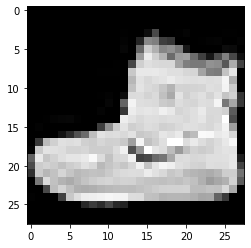

In [7]:
# 샘플 이미지 확인
import matplotlib.pyplot as plt
plt.imshow(x_train_all[0], cmap='gray')
plt.show()

In [8]:
# 타깃의 내용과 의미 확인
# y_train_alll: 0~9까지의 정수로 이루어진 클래스 레이블
print(y_train_all[:10])
# 각 레이블의 의미
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트',
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']
print(class_names[y_train_all[0]])

[9 0 0 3 0 2 7 2 5 5]
앵클부츠


In [9]:
# 타깃 분포 확인하기
# 훈련셋의 타깃 값들이 고르게 분포됐는지 확인
import numpy as np

np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [10]:
# 훈련셋과 검증셋 고르게 나누기
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
                                                  stratify=y_train_all, test_size=0.2, random_state=42)
print(np.bincount(y_train))
print(np.bincount(y_val))

[4800 4800 4800 4800 4800 4800 4800 4800 4800 4800]
[1200 1200 1200 1200 1200 1200 1200 1200 1200 1200]


In [11]:
# 입력 데이터 0~255사이의 픽셀값을 0~1사이로 정규화
x_train = x_train / 255
x_val = x_val / 255

# 훈련셋과 검증셋 차원 변경
# 훈련셋과 검증셋의 2, 3번째 차원(이미지 픽셀)을 합치고 펼침
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


### 타깃 데이터를 준비하고 다중 분류 신경망 훈련
> 데이터셋은 10개의 클래스로 구성되어있다. 그러나 y_train, y_val에 저장된 값들은 0~9 사이의 정수값 하나로 출력뉴런(10개여야 함)에 대응되지 않는다. 그러므로 이에 맞게 타깃데이터를 변경해야 한다.
1. 타깃을 **원-핫 인코딩(one-hot encoding)**으로 변환
    - 타깃값 1개 → 길이가 10인 배열
    - 타깃의 정수값에 해당하는 원소 = 1, 나머지 = 0
2. 배열의 각 원소를 뉴런의 출력값과 비교
    - 가장 큰 출력값의 인덱스가 타깃과 동일한지 비교


In [12]:
# 원-핫 인코딩 예제
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [13]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

print(y_train_encoded.shape, y_val_encoded.shape)
print(y_train[0], y_train_encoded[0])

(48000, 10) (12000, 10)
6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [14]:
# MultiClassNetwork 클래스로 다중 분류 신경망 훈련
fc = MultiClassNetwork(units=100, batch_size=256)
fc.fit(x_train, y_train_encoded,
       x_val=x_val, y_val=y_val_encoded, epochs=40)

........................................

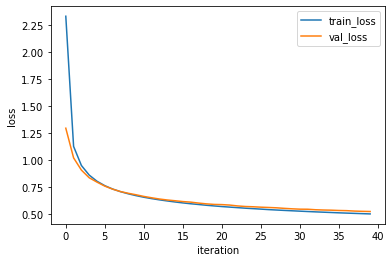

In [15]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [16]:
fc.score(x_val, y_val_encoded)

0.8150833333333334

## Tensorflow와 keras 사용해 신경망 구축
> keras: 딥러닝 패키지를 편리하게 사용하기 위해 만들어진 Wrapper 패키지로 텐서플로우나 씨아노 등을 편리하게 사용할 수 있다.

### 간단한 신경망을 텐서플로우와 케라스로 구현
```
import tensorflow as tf

# 훈련할 가중치 변수 선언
w = tf.Variable(tf.zeros(shape=(1)))
b = tf.Variable(tf.zeros(shape=(1)))

# 경사하강법 옵티마이저 설정
optimizer = tf.optimizers.SGD(lr = 0.01)

# 에폭 횟수만큼 훈련
num_epochs = 10
for step in range(num_epochs):
    # 자동 미분(주어진 입력 변수에 대한 연산의 gradient를 계산하는 것)을 위한 연산 과정 기록
    # GradientTape: 자동 미분을 위한 API로 context 안에서 실행된 모든 연산을 tape에 기록
    with tf.GradientTape() as tape:
        z_net = w * x_train + b
        z_net = tf.reshape(z_net, [-1])
        sqr_errors = tf.square(y_train - z_net)
        mwan_cost = tf.reduce_mean(sqr_errors)
    # 손실함수에 대한 가중치의 gradient계산 
    grads = tape.gradient(mean_cost, [w, b])
    # 옵티마이저에 gradient반영
    optimizer.apply_gradients(zip(grads, [w, b]))
```
이러한 긴 과정을 케라스를 이용하면 아래와 같이 간단하게 구현할 수 있다.
```
# 신경망 모델 만듦
model = tf.keras.models.Sequential()
# 완전 연결층 추가
model.add(tf.keras.layers.Dense(1))
# 옵티마이저와 손실함수 지정
model.compile(optimizer='sgd', loss='mse')
# 훈련 데이터를 사용해 에폭 횟수만큼 훈련
model.fit(x_train, y_train, epochs=10)
```  
---  
이와 같이 케라스를 사용하면 직관적으로 인공신경망의 층을 설계할 수 있다. 모델과 층이 명확하게 구분된다는 것이다.
- Sequential 클래스: 순차적으로 층을 쌓은 신경망 모델
    - 사용 방법 1. 클래스의 객체를 생성할 때 층을 추가하는 방법
        ```
        from tensorflow.keras import Sequential
        from tensorflow.keras.layers import Dense
        model = Sequential([Dense(...), ...])
        ```
    - 사용 방법 2. 클래스의 객체를 생성한 후 add() 메서드를 사용해 층을  추가하는 방법
        ```
        dense = Dense(...)
        model.add(dense)
        ```
        ```
        moodel = Sequential()
        model.add(Dense(...))
        model.add(Dense(...))
        ```
- Dense 클래스: 모델에 포함될 완전 연결층
    - unit: 층의 유닛 개수
    - activation: 기본값은 None. sigmoid, tanh, relu등을 지정할 수 있다.
    - kernel_initializer: 가중치 규제

---
### 최적화 알고리즘과 손실 함수 설정
- 최적화 알고리즘 지정
```
# sgd: 경사 하강법, 학습률 기본 값=0.01
model.compile(optimizer='sgd', ...)
```
- 손실 함수 지정
```
# 제곱 오차: mse...
# 로지스틱 손실: binary_crossentropy...
# 다중 분류: categorical_crossentropy...
model.compile(optimizer='sgd', loss='categorical_crossentropy')
```
---
### 모댈 훈련 및 예측
- 훈련 fit → 예측 predict → 평가 evaluate
```
model = Sequential()
model.add(Dense(...))
model.add(Dense(...))
model.compile(optimizer='...', loss'...')
model.fit(x, y, epochs=...)
model.predict(x)
model.evaluate(x, y)
```
---
### 케라스로 다중 분류 신경망 만들기
1. 모델 생성하기
2. 은닉층과 출력층을 모델에 추가하기
3. 최적화 알고리즘과 손실 함수 지정하기
    - metrics: 훈련 과정 기록으로 정확도를 남기기 위함이다. 값을 설정하지 않으면 loss값이 기록된다. 모델의 정확도를 보고싶으면 accuracy를 매개변수로 넣어주면 된다.
4. 모델 훈련하기
5. 손실과 정확도 그래프 그리기
6. 검증 셋 정확도 계산하기
    - evaluate: 손실값과 metrics 매개변수에 추가한 측정 지표를 계산해 반환

In [20]:
# 1
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

model = Sequential()

# 2
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

# 3
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# 4
history = model.fit(x_train, y_train_encoded, epochs=40, validation_data=(x_val, y_val_encoded))

Epoch 1/40
1500/1500 [==============================] - 4s 3ms/step - loss: 1.7750 - accuracy: 0.5276 - val_loss: 0.9676 - val_accuracy: 0.7305
Epoch 2/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.8974 - accuracy: 0.7357 - val_loss: 0.7508 - val_accuracy: 0.7571
Epoch 3/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.7300 - accuracy: 0.7647 - val_loss: 0.6628 - val_accuracy: 0.7802
Epoch 4/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6592 - accuracy: 0.7777 - val_loss: 0.6127 - val_accuracy: 0.7931
Epoch 5/40
1500/1500 [==============================] - 3s 2ms/step - loss: 0.6115 - accuracy: 0.7924 - val_loss: 0.5763 - val_accuracy: 0.8032
Epoch 6/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5831 - accuracy: 0.8031 - val_loss: 0.5513 - val_accuracy: 0.8113
Epoch 7/40
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5511 - accuracy: 0.8100 - val_loss: 0.5306 - val_accuracy:

In [22]:
# 5
# 어떤 측정 지표들이 들어있는지 확인
print(history.history.keys())
# loss, accuracy: 훈련셋의 손실과 정확도
# val_loss, val_accuracy: 검증셋의 손실과 정확도

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


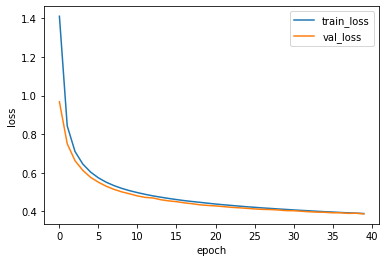

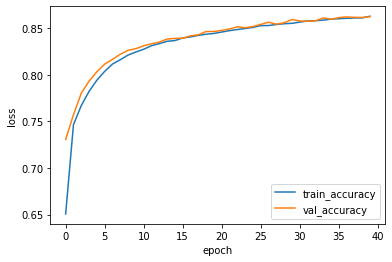

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [24]:
# 6
loss, accuracy = model.evaluate(x_val, y_val_encoded, verbose=0)
print(accuracy)

0.8621666431427002
